# Installation

Nowadays, most GPU packages are easy to install: Just do a `Pkg.add("oneAPI")` and everything should work out-of-the-box. In the case of oneAPI, we currently only support Linux, where the necessary drivers are part of the kernel, so there's no need to install anything except for the oneAPI.jl package itself:

In [46]:
#using Pkg
#Pkg.add("oneAPI")

In [47]:
using oneAPI

With oneAPI.jl, a good way to check if the package is functional is to call the `versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

In [48]:
oneAPI.versioninfo()

Binary dependencies:
- NEO_jll: 21.22.19967+0
- libigc_jll: 1.0.7423+0
- gmmlib_jll: 21.1.3+0
- SPIRV_LLVM_Translator_jll: 11.0.0+2
- SPIRV_Tools_jll: 2020.6.0+0

Toolchain:
- Julia: 1.6.2
- LLVM: 11.0.1

1 driver:
- 00000000-0000-0000-1693-ca3c01010000 (v1.1.0, API v1.1.0)

1 device:
- Intel(R) HD Graphics P630 [0x591d]


# Array programming

The easiest way to program GPUs in Julia is by using array operations. In oneAPI.jl, that's done with the `oneArray` type:

In [49]:
a = oneArray([1,2,3,4])

4-element oneArray{Int64, 1}:
 1
 2
 3
 4

In [50]:
a .+= 1

4-element oneArray{Int64, 1}:
 2
 3
 4
 5

These two operations demonstrate the different tasks that `oneArray` has:
1. a container for storing GPU data and managing its lifetime
2. a abstraction for executing parallel operations on the GPU

## Scalar indexing

It's crucial to remember that `oneArray` is an abstraction that derives parallelism from its operations. oneAPI.jl is **not** a parallelizing compiler, which e.g. means you cannot use element-wise for loops and expect those to execute efficiently on the GPU:

In [51]:
# ignore this
task_local_storage(:ScalarIndexing, oneAPI.GPUArrays.ScalarWarn);

In [52]:
for i in eachindex(a)
    a[i] += 1
end
a

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fbd70f8acb0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/tim/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


4-element oneArray{Int64, 1}:
 3
 4
 5
 6

As you can see, the operation *did* complete successfully, but with a nasty warning. In fact, the operation did not complete on the GPU, but on the CPU, while fetching and writing each value back separately. Needless to say, that's extremely slow.

In the latest version of oneAPI.jl, scalar indexing is disallowed by default in non-interactive code. With interactive sessions (e.g. in the REPL, or here in Jupyter), the behavior is still allowed because it's a convenient tool to get up to speed when porting code. You can explicitly enable or disable the feature too:

In [53]:
oneAPI.allowscalar(false)
a[1]

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

When porting code, it's often convenient to temporarily allow scalar indexing of certain operations. This can be done using the `@allowscalar` macro:

In [ ]:
oneAPI.@allowscalar a[1]

3

## Array interface

The `oneArray` type is implemented to resemble `Base.Array`, making it easy to get up to speed, but also making it possible to write generic code that works on all kinds of arrays:

In [ ]:
# allocate data
a = oneArray{Float32}(undef, 10)

In [ ]:
# allocate & initialize
b = oneArray{Float32}([i for i in 1:length(a)])

In [ ]:
copyto!(a, b)

In [ ]:
fill!(a, 42)

In [ ]:
similar(a)

Some array operations don't take an array type, so it's impossible to dispatch to a GPU-specific version. For those, the oneAPI module has an unexported version:

In [ ]:
c = oneAPI.ones(length(a))

## Vendor libraries

Whereas packages like oneAPI.jl and AMDGPU.jl integrate with vendor libraries like CUBLAS or rocFFT to implement certain array interfaces like methods from LinearAlgebra.jl, oneAPI.jl currently does not yet support the Intel vendor libraries. Contributions are greatly appreciated here!

## Higher-order abstractions

The real flexibility of Julia's arrays comes from its higher-order abstractions, where you combine the abstraction with custom code:

In [ ]:
a = oneAPI.ones(10)
broadcast(a) do x
    x += 1
end

In [ ]:
# or written more succinctly:
a .+ 1

These abstractions are really powerful, because while we only need to provide a single generic implementation in oneAPI.jl, it makes it possible to generate specialized kernels for your application. Many more are supported:

In [ ]:
map(a) do x
    x + 1
end

In [ ]:
reduce(+, a)

It is important to note here that **oneAPI.jl is not a tensor compiler**. It implements these abstractions directly, and generates scalar kernels. Multiple operations are generally not fused together, and generic functions that operate on other arrays (like mapping over `eachcol`, or using `eachslice`) do not directly result in a GPU kernel:

In [54]:
a = oneAPI.ones(10, 10)
broadcast(eachcol(a)) do x
    sum(x)
end

10-element Vector{Float64}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

Performing the `sum` within the `map` results in one kernel launch per column, which is slow and doesn't efficiently use the GPU:

In [55]:
using BenchmarkTools
@benchmark oneAPI.@sync broadcast(eachcol($a)) do x
    sum(x)
end

BenchmarkTools.Trial: 247 samples with 1 evaluation.
 Range (min … max):   2.432 ms … 52.234 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.953 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.379 ms ± 14.013 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▇▄▄▂▃▁ ▁ ▄ ▃ ▁▁  ▂  ▂    ▁                                 
  ██████████████▆██▇▃█▆▄█▄██▆█▆▇▇▃▇▄▃▇▄▆▇▇▄▆▃▁▆▄█▆▃▄▇▄▃▁▄▃▇▇▄ ▄
  2.43 ms         Histogram: frequency by time          51 ms <

 Memory estimate: 91.70 KiB, allocs estimate: 1887.

Instead, if the array operation supports it, you should merge them into a single invocation:

In [56]:
sum(a; dims=2)

10×1 oneArray{Float64, 2}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [57]:
@benchmark oneAPI.@sync sum(a; dims=2)

BenchmarkTools.Trial: 3187 samples with 1 evaluation.
 Range (min … max):  150.481 μs … 8.067 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):       1.207 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.559 ms ± 1.241 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▄▂ ▄▃▂                                                      
  ███▆███▆▆█▇▆▅▆▆▆▆▅▅▅▅▅▅▆▆▆▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▂▂▂▂▂▂▂▂ ▄
  150 μs          Histogram: frequency by time        6.23 ms <

 Memory estimate: 8.64 KiB, allocs estimate: 169.

In other cases, the operation will just refuse the compile because very few array operations are supported in actual device code:

In [58]:
broadcast(a, eachcol(a)) do x,Y
    x + sum(Y)
end

LoadError: GPU compilation of kernel broadcast_kernel(oneAPI.oneKernelContext, oneDeviceMatrix{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#29#30", Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{SubArray{Float64, 1, oneArray{Float64, 2}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#29#30", Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{SubArray{Float64, 1, oneArray{Float64, 2}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{SubArray{Float64, 1, oneArray{Float64, 2}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{SubArray{Float64, 1, oneArray{Float64, 2}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{SubArray{Float64, 1, oneArray{Float64, 2}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}} which is not isbits.



Tensor packages like Tullio.jl can help here, making it possible to express complex expressions in a way that can still get compiled to a single kernel. However, this requires a KernelAbstractions.jl back-end for oneAPI.jl, which hasn't been completed yet.

At some point you may need even more control, or better performance. For that, you can write your own kernels.

# Kernel programming

Where array operations have implicit parallelism that oneAPI.jl can use to execute the operation in parallel on your GPU, with kernels the programmer is responsible to apply the available parallel execution resources to the operation at hand.

At a high level, that's pretty easy, you just need to write a scalar function and launch that function in parallel using the `@oneapi` macro and its `items` keyword argument:

In [ ]:
function vadd(c, a, b)
    i = get_local_id()
    c[i] = a[i] + b[i]
    return
end

a = oneArray(1:10)
b = oneArray(2:2:20)
c = similar(a)
@oneapi items=length(a) vadd(c, a, b)
c

10-element oneArray{Int64, 1}:
  3
  6
  9
 12
 15
 18
 21
 24
 27
 30

But kernel programming quickly becomes much more tricky, because:
- you need to respect hardware limitations
- you need to efficiently use hardware resources
- not every operation maps cleanly on a scalar kernel

## Hardware limitations

For example, let's run our `vadd` kernel on a larger array:

In [ ]:
a = oneArray(1:100000)
b = oneArray(2:2:200000)
c = similar(a)
@oneapi items=length(a) vadd(c, a, b)

LoadError: ZeError: group size dimension is not valid for the kernel or device (code 2013265939, ZE_RESULT_ERROR_INVALID_GROUP_SIZE_DIMENSION)

The reason this fails is due to launching too many threads:

In [ ]:
oneL0.compute_properties(device()).maxTotalGroupSize

256

Instead, we need to launch multiple so-called *groups* and adapt our kernel index calculation:

In [ ]:
function vadd(c, a, b)
    i = get_global_id()
    if i <= length(a)
        c[i] = a[i] + b[i]
    end
    return
end
@oneapi items=256 groups=cld(length(a),256) vadd(c, a, b)
c

100000-element oneArray{Int64, 1}:
      3
      6
      9
     12
     15
     18
     21
     24
     27
     30
     33
     36
     39
      ⋮
 299967
 299970
 299973
 299976
 299979
 299982
 299985
 299988
 299991
 299994
 299997
 300000

## Automatic group sizes

Hard-coding a limit of 256 threads, or even looking up the device limit, is insufficient. In reality, maximum number of threads you can launch also depends on the kernel, and how many hardware resources it uses.

You can figure out the actual thread limit by compiling the kernel and before launching it inspect its properties:

In [ ]:
kernel = @oneapi launch=false vadd(c, a, b)

oneAPI.HostKernel{vadd, Tuple{oneDeviceVector{Int64, 1}, oneDeviceVector{Int64, 1}, oneDeviceVector{Int64, 1}}}(oneAPI.oneL0.ZeKernel(oneAPI.oneL0.ZeModule(Ptr{oneAPI.oneL0._ze_module_handle_t} @0x0000000004f19cc0, oneAPI.oneL0.ZeContext(Ptr{oneAPI.oneL0._ze_context_handle_t} @0x0000000002599940, oneAPI.oneL0.ZeDriver(Ptr{oneAPI.oneL0._ze_driver_handle_t} @0x0000000003938190)), oneAPI.oneL0.ZeDevice(Ptr{oneAPI.oneL0._ze_device_handle_t} @0x00000000037b9910, oneAPI.oneL0.ZeDriver(Ptr{oneAPI.oneL0._ze_driver_handle_t} @0x0000000003938190))), Ptr{oneAPI.oneL0._ze_kernel_handle_t} @0x00000000025eed80))

oneAPI provides an API to figure out a good group size (not only respecting device limits, but optimizing actual resource usage), and how many blocks you should ideally launch to optimally use the GPU:

In [ ]:
config = oneAPI.suggest_groupsize(kernel.fun, length(a))

oneAPI.oneL0.ZeDim3(32, 1, 8)

With this information, we can compute the actual launch configuration and continue launching the kernel:

In [ ]:
@show items = min(length(a), config.x)
@show groups = cld(length(a), items)
kernel(c, a, b; items, groups)

items = min(length(a), config.x) = 32
groups = cld(length(a), items) = 3125


## Parallel programming

Another problem with GPU programming is that not all operations map cleanly onto scalar kernels. As a simple example, let's try and implement a kernel that reduces all the values in an array according to a given operation.

### Naive loop

You might start off with a simple `for` loop doing the reduction on the GPU as you would on the CPU:

In [ ]:
function reduce_singlethread(op, a, b)
    for i in 1:length(a)
        b[] = op(b[], a[i])
    end
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=1 reduce_singlethread(+, a, b)
oneAPI.@allowscalar b[]

136

In [ ]:
# just to be sure
sum(1:16)

136

In [ ]:
@benchmark oneAPI.@sync @oneapi items=1 reduce_singlethread(+, $(oneArray(rand(Float32, 1024,1024))), $(oneAPI.zeros(Float32, 1)))

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  209.978 ms … 212.975 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     211.164 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   211.274 ms ± 764.068 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

              ▃  ▃    ▃ ▃      ▃  █          ▃                   
  ▇▁▁▁▇▁▁▁▁▇▁▇█▁▁█▁▁▁▁█▁█▁▁▇▁▁▁█▁▁█▁▁▁▇▁▁▁▇▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▇ ▁
  210 ms           Histogram: frequency by time          213 ms <

 Memory estimate: 2.00 KiB, allocs estimate: 43.

This is a bad implementation though! It only uses a single thread, defeating the point of using a GPU with its thousands of threads.

### Atomics

To benefit from the GPU, we *need* to launch multiple threads. Since that would trample over the output value, we could try and use atomics:

In [ ]:
function reduce_atomic(op, a, b)
    i = get_global_id()
    oneAPI.@atomic b[] = op(b[], a[i])
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=length(a) reduce_atomic(+, a, b)
oneAPI.@allowscalar b[]

136

In [ ]:
@benchmark oneAPI.@sync @oneapi items=256 groups=4096 reduce_atomic(+, $(oneArray(rand(Float32, 1024,1024))), $(oneAPI.zeros(Float32, 1)))

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.051 s …    1.052 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.051 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.051 s ± 680.699 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁        █       ▁                                       ▁  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  150 s          Histogram: frequency by time          150 s <

 Memory estimate: 2.03 KiB, allocs estimate: 45.

Even slower! Turns out,a tomic operations are expensive, and result in serialization of execution.

### Parallel block reduction

We really want a kind of parallel reduction where threads can indepedently perform computations, only to synchronize when absolutely necessary. One possible such parallel strategy looks as follows:

<div>
<img src="./parallel_reduction.png" width="500"/>
</div>
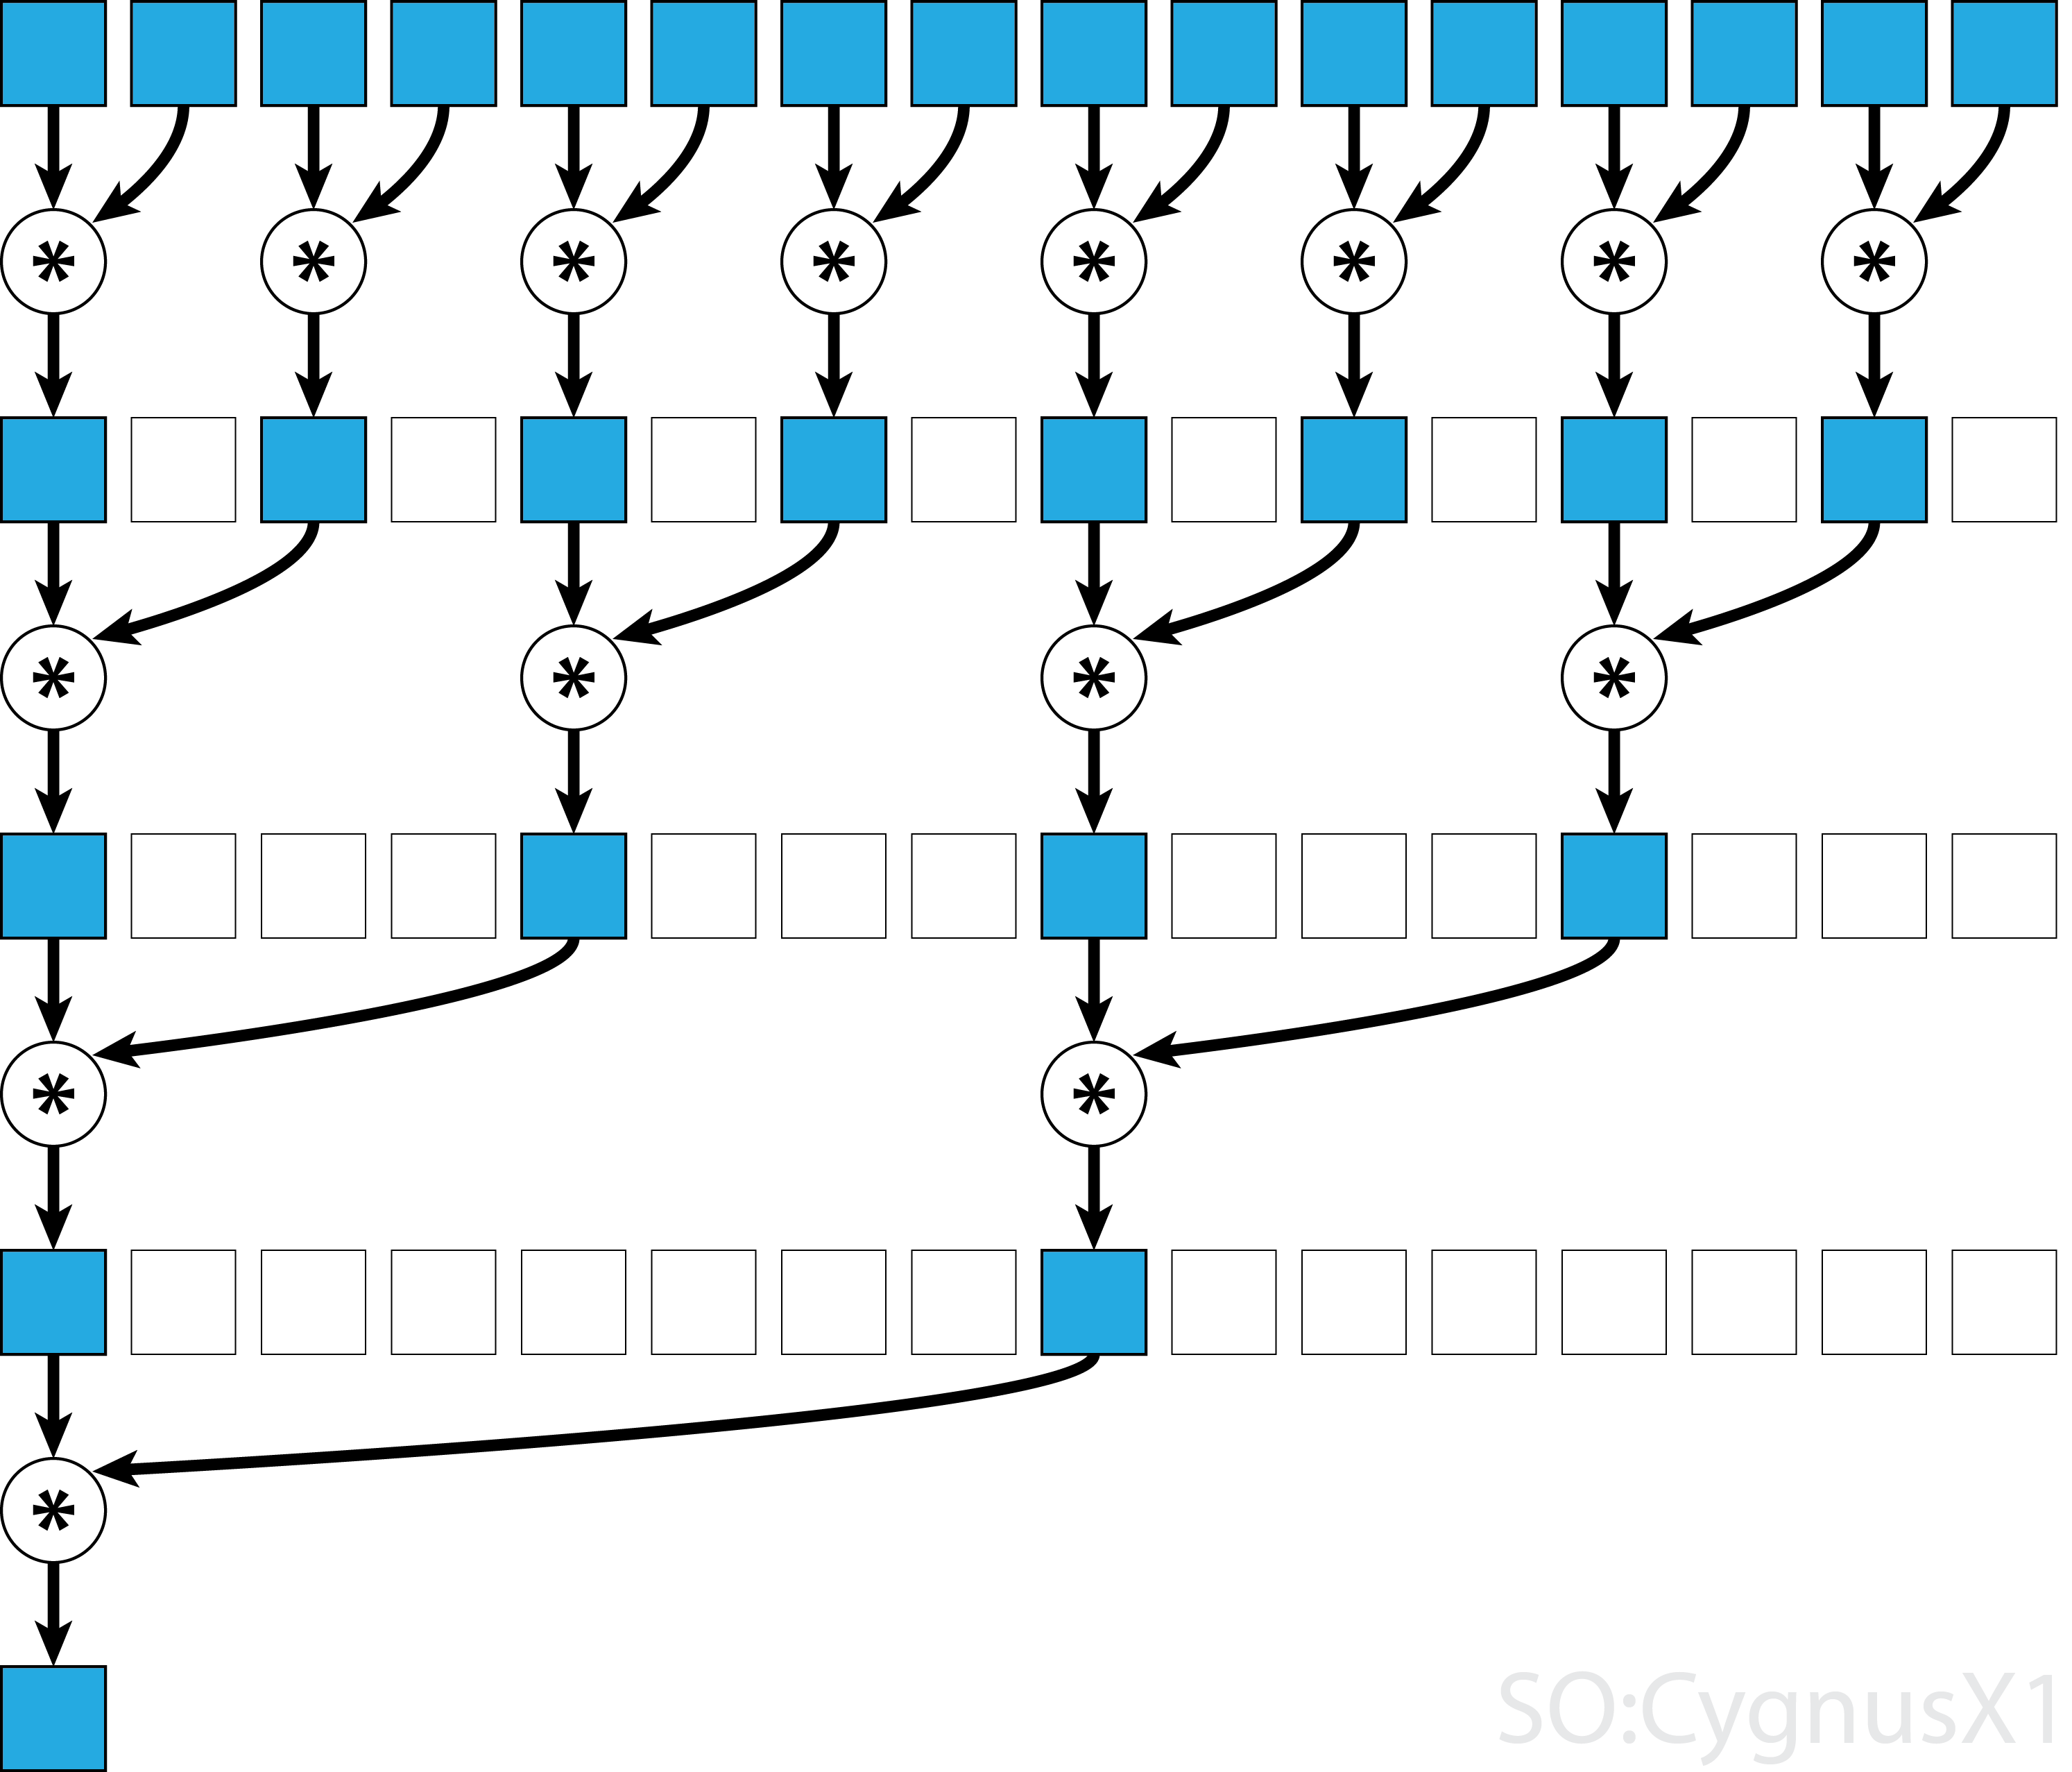

These kinds parallel algorithms can be tricky to implement though, so let's start with a single-block version:

In [ ]:
function reduce_block(op, a, b)
    elements = get_local_size()*2
    thread = get_local_id()

    # parallel reduction of values in a block
    d = 1
    while d < elements
        barrier()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && index+d <= length(a)
            oneAPI.@println "thread $thread: a[$index] + a[$(index+d)] = $(a[index]) + $(a[index+d]) = $(op(a[index], a[index+d]))"
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
        thread == 1 && oneAPI.@println()
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=cld(length(a),2) reduce_block(+, a, b)
oneAPI.@allowscalar b[]

thread 2: a[3] + a[4] = 3 + 4 = 7
thread 3: a[5] + a[6] = 5 + 6 = 11
thread 4: a[7] + a[8] = 7 + 8 = 15
thread 5: a[9] + a[10] = 9 + 10 = 19
thread 6: a[11] + a[12] = 11 + 12 = 23
thread 7: a[13] + a[14] = 13 + 14 = 27
thread 8: a[15] + a[16] = 15 + 16 = 31
thread 2: a[5] + a[7] = 11 + 15 = 26
thread 3: a[9] + a[11] = 19 + 23 = 42
thread 4: a[13] + a[15] = 27 + 31 = 58
thread 2: a[9] + a[13] = 42 + 58 = 100
thread 1: a[1] + a[2] = 1 + 2 = 3

thread 1: a[1] + a[3] = 3 + 7 = 10

thread 1: a[1] + a[5] = 10 + 26 = 36

thread 1: a[1] + a[9] = 36 + 100 = 136



136

Now let's extend that to a reduction of the entire array (with more elements than fit in a single block) using a simple `for` loop that first reduces across blocks. Such loops aren't always bad: Here, the loop is executed by all threads, in parallel, so we don't throw away the parallel nature of the GPU:

In [ ]:
function reduce_grid(op, a, b)
    elements = get_local_size()*2
    thread = get_local_id()
    
    # serial reduction of values across blocks
    i = thread+elements
    while i <= length(a)
        a[thread] = op(a[thread], a[i])
        i += elements
    end

    # parallel reduction of values in a block
    d = 1
    while d < elements
        barrier()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && index+d <= length(a)
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=cld(length(a),2) reduce_grid(+, a, b)
oneAPI.@allowscalar b[]

136

In [ ]:
@benchmark oneAPI.@sync @oneapi items=256 reduce_grid(+, $(oneArray(rand(Float32, 1024,1024))), $(oneAPI.zeros(Float32, 1)))

BenchmarkTools.Trial: 6598 samples with 1 evaluation.
 Range (min … max):  683.503 μs …  2.801 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     732.014 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   750.755 μs ± 70.312 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █         ▃                                                  
  ██▇▃▂▂▄▇█▅▅█▅▃▃▄▄▃▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁ ▂
  684 μs          Histogram: frequency by time          933 μs <

 Memory estimate: 2.00 KiB, allocs estimate: 43.

Quite a bit better, but not ideal since we're only launching a single block now. That's still underutilizing the GPU, which needs multiple blocks so that it can switch between them to hide latency (remember the `blocks` output from the occupancy API).


### Atomic grid reduction

If we want to launch multiple blocks performing block reduction in parallel, we need a way to reduce the resulting value from each block. Sadly, we can't perform that step in parallel: Blocks are independent, and may not even run at the same time, so we can't synchronize between threads from different blocks.

However, going back to the beginning, we can use atomics to directly write to the output from each block:

In [ ]:
function reduce_grid_atomic(op, a, b)
    elements = get_local_size()*2
    thread = get_local_id()
    block = get_group_id()
    offset = (block-1) * elements

    # parallel reduction of values in a block
    d = 1
    while d < elements
        barrier()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && offset+index+d <= length(a)
            a[offset+index] = op(a[offset+index], a[offset+index+d])
        end
        d *= 2
    end
    
    # atomic reduction of this block's value
    if thread == 1
        oneAPI.@atomic b[] = op(b[], a[offset + 1])
    end
    
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=2 groups=4 reduce_grid_atomic(+, a, b)
oneAPI.@allowscalar b[]

136

In [ ]:
@benchmark oneAPI.@sync @oneapi items=256 groups=2048 reduce_grid_atomic(+, $(oneArray(rand(Float32,1024,1024))), $(oneAPI.zeros(Float32,1)))

BenchmarkTools.Trial: 1340 samples with 1 evaluation.
 Range (min … max):  3.582 ms …  5.649 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.711 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.723 ms ± 95.200 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂▃▁▁▂▄▃▂▃█▃▁▃▃                                       
  ▃▃▃▄▅▇▆████████████████▆▇▅▆▄▆▃▅▄▃▃▃▂▃▃▃▃▃▃▂▂▂▂▃▂▂▂▁▂▂▂▂▁▁▂ ▄
  3.58 ms        Histogram: frequency by time         440 ms <

 Memory estimate: 2.03 KiB, allocs estimate: 45.

Interestingly, atomic operations greatly reduce our kernel, whereas with CUDA GPUs this sped up the implementation.

### Shared memory

Another common optimization comes from the fact that blocks of threads are executed on separate processors that have their own memory shared between the threads running on that multiprocessor. Accessing that memory is faster than going to global memory, so it is often used for caching loads, and for communicating betweent threads. Both those aspects apply here:

In [ ]:
function reduce_grid_atomic_shmem(op, a::AbstractArray{T}, b) where {T}
    elements = get_local_size()*2
    thread = get_local_id()
    block = get_group_id()
    offset = (block-1) * elements

    # shared mem to buffer memory loads
    shared = @LocalMemory(T, (512,))
    @inbounds shared[thread] = a[offset+thread]
    @inbounds shared[thread+get_local_size()] = a[offset+thread+get_local_size()]

    # parallel reduction of values in a block
    d = 1
    while d < elements
        barrier()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && offset+index+d <= length(a)
            shared[index] = op(shared[index], shared[index+d])
        end
        d *= 2
    end
    
    # atomic reduction
    if thread == 1
        oneAPI.@atomic b[] = op(b[], shared[1])
    end
    
    return
end

a = oneArray{Int32}(1:16)
b = oneArray{Int32}([0])
@oneapi items=4 groups=2 reduce_grid_atomic_shmem(+, a, b)
oneAPI.@allowscalar b[]

136

In [ ]:
@benchmark oneAPI.@sync @oneapi items=256 groups=2048 reduce_grid_atomic_shmem(+, $(oneArray(rand(Float32,1024,1024))), $(oneAPI.zeros(Float32,1)))

BenchmarkTools.Trial: 3058 samples with 1 evaluation.
 Range (min … max):  1.555 ms …  3.503 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.615 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.625 ms ± 62.253 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂▇▆▄▁   ▄▅█▃ ▁  ▁▇▄▁                                       
  ▃███████▆███████▆████▆▆▅▅▇██▇▅▅▄▃▄▄▅▄▃▃▃▂▂▃▃▃▂▂▂▂▂▁▂▁▁▂▂▁▁ ▄
  1.56 ms        Histogram: frequency by time        1.78 ms <

 Memory estimate: 2.03 KiB, allocs estimate: 45.

This did speed up the previous implementation, so it would be good to combine it with the non-atomic version for maximal performance.

### Conclusion

And like that, the story keeps going. It should be noted that oneAPI.jl at this point is still in heavy development, with focus on functionality as opposed to performance. For example, the (non-general) optimizations we performed here should be good to add to the current implementation of `mapreducedim!` in oneAPI.jl, which is a bit slower:

In [ ]:
@benchmark oneAPI.@sync sum($(oneArray(rand(Float32,1024,1024))))

BenchmarkTools.Trial: 768 samples with 1 evaluation.
 Range (min … max):  4.752 ms … 10.074 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.333 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.496 ms ±  1.204 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅▆▆█▂       ▂   ▁▅▅▃▂▁▁  ▁        ▁     ▁                  
  ▆█████▇▅▄▃▅▃▆█▇▅████████▆██▇▅▄▅▃▁▅▅█▅▅▅▅▅█▅▂▆▅▃▄▅▂▅▄▃▂▃▂▃▂ ▄
  4.75 ms        Histogram: frequency by time        9.23 ms <

 Memory estimate: 28.78 KiB, allocs estimate: 516.

And for completeness, compared to `Base.sum`:

In [ ]:
@benchmark sum($(rand(1024,1024)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  182.191 μs … 590.865 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     208.179 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   224.137 μs ±  47.473 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█                                                             
  ██▇▆▆▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  182 μs           Histogram: frequency by time          400 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

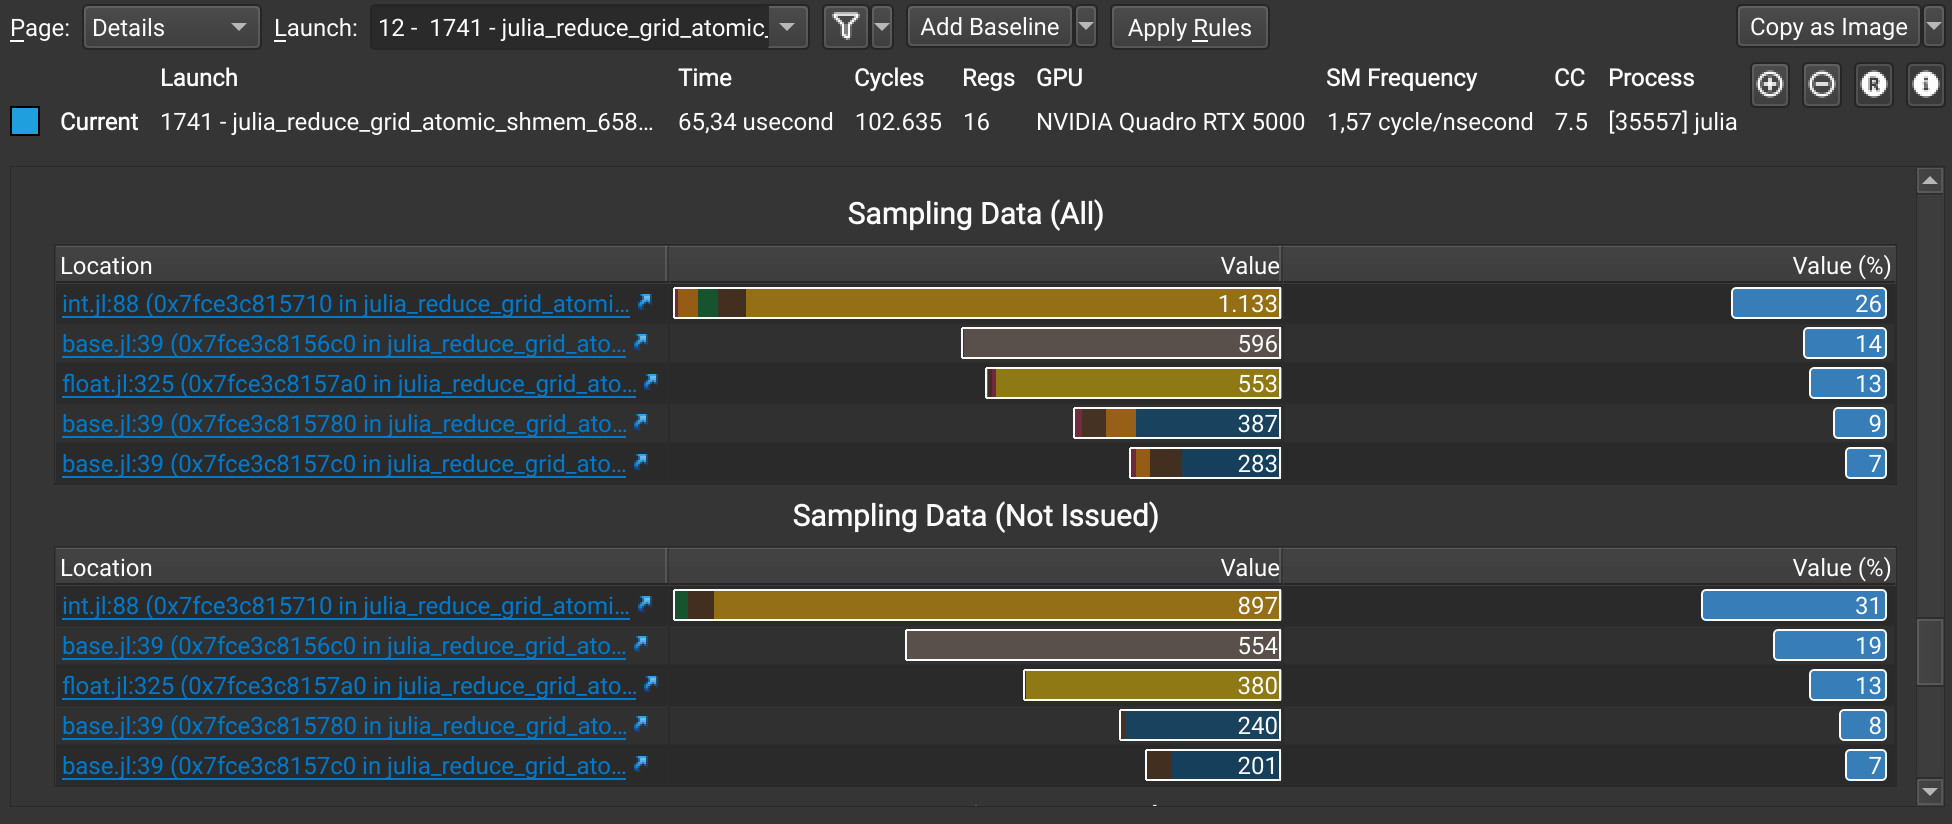

# Common issues

The most frequent issues with the GPU stack come from expected CPU functionality not being implemented or supported on the GPU.

## Unsupported array operations

For example, with array expressions, missing operations often lead to the use of iterating fallback functionality, which triggers the scalar iteration error:

In [ ]:
using LinearAlgebra
eigen(oneArray(rand(2,2)))

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fbd70f8acb0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/tim/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


LoadError: ArgumentError: cannot take the host address of a oneArray{Float64, 2}

This doesn't mean that this operation cannot work on the GPU, but just that nobody has taken the time to implement `eigen` (or one of the functions it calls) using either functionality from NVIDIA's libraries, or using a native GPU kernel written in Julia.

With array operations, it's also easy to get an error when using unsupported data with GPU kernels. Essentially, every value passed to a kernel needs to be an `isbits` type. An easy way to violate this, is to pass a CPU array to a GPU array operation:

In [ ]:
a = oneArray(rand(2,2))
b = rand(2)
broadcast(a, b) do x, y
    x + y
end

LoadError: GPU compilation of kernel broadcast_kernel(oneAPI.oneKernelContext, oneDeviceMatrix{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#21#22", Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#21#22", Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{oneDeviceMatrix{Float64, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{Float64} which is not isbits.



## Unsupported kernel operations

In device code, i.e. code that actually runs on the GPU as opposed to a CPU method (like `eigen`) that's implemented using GPU kernels, the story is a little more complicated. Essentially, not all of the Julia language is supported. If you use unsupported functionality, you will see a compilation error:

In [ ]:
a = oneArray(rand(1))
broadcast(a) do x
    print(x)
end

LoadError: InvalidIRError: compiling kernel broadcast_kernel(oneAPI.oneKernelContext, oneDeviceVector{Nothing, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, var"#23#24", Tuple{Base.Broadcast.Extruded{oneDeviceVector{Float64, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_subtype)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#23[22m
[90m   @ [39m[90m./[39m[90;4mIn[38]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/.julia/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#23[22m
[90m   @ [39m[90m./[39m[90;4mIn[38]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/.julia/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m
Reason: unsupported call to an unknown function (call to gpu_malloc)
Stacktrace:
 [1] [0m[1mmalloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:88[0m
 [2] [0m[1mgc_pool_alloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:119[0m
 [3] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [4] [0m[1m#23[22m
[90m   @ [39m[90m./[39m[90;4mIn[38]:3[0m
 [5] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [6] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [7] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [8] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/.julia/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m

To help debugging this, there's multiple stacktraces being displayed: one pointing to each unsupported operation in a GPU kernel, and finally a host stack trace pointing to the CPU code that invoked the kernel. Often, that's sufficient to find and resolve the issue.

Sometimes though, the issue is more subtle:

In [ ]:
function bad_kernel(a)
    a[get_local_idx()] = 0
    return
end

@oneapi bad_kernel(oneArray([1]))

LoadError: InvalidIRError: compiling kernel bad_kernel(oneDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported use of an undefined name (use of 'get_local_idx')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported call to an unknown function (call to gpu_malloc)
Stacktrace:
 [1] [0m[1mmalloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:88[0m
 [2] [0m[1mgc_pool_alloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:119[0m
 [3] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m

Here, the issue isn't obvious, with the stack traces pointing to seemingly OK code. In such cases, code reflection utilities can help. All GPU back-ends based on GPUCompiler.jl (i.e. oneAPI.jl, AMDGPU.jl and oneAPI.jl) have device-versions of typical reflection utilities like `@code_warntype` or `code_llvm`:

In [ ]:
@device_code_warntype @oneapi bad_kernel(oneArray([1]))

CompilerJob of kernel bad_kernel(oneDeviceVector{Int64, 1}) for GPUCompiler.SPIRVCompilerTarget

Variables
  #self#::Core.Const(bad_kernel)
  a::oneDeviceVector{Int64, 1}

Body::Nothing
1 ─ %1 = Main.get_local_idx()::Any
│        Base.setindex!(a, 0, %1)
└──      return nothing


LoadError: InvalidIRError: compiling kernel bad_kernel(oneDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported use of an undefined name (use of 'get_local_idx')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m
Reason: unsupported call to an unknown function (call to gpu_malloc)
Stacktrace:
 [1] [0m[1mmalloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:88[0m
 [2] [0m[1mgc_pool_alloc[22m
[90m   @ [39m[90m~/.julia/packages/GPUCompiler/wHjqZ/src/[39m[90;4mruntime.jl:119[0m
 [3] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[39]:2[0m

From this view, it's much more clear that `threadId` was a typo and should be `threadIdx` instead. Note that in case your issue lies in a function that's called by the kernel, and isn't directly visible by the `@device_code_warntype` output, you can use Cthulhu.jl to interactively explore code by using `@device_code_warntype interactive=true ...` (the equivalent of Cthulhu's `@descend_code_warntype`).

And just to demonstrate the other reflection utilities:

In [ ]:
function good_kernel(a)
    @inbounds a[get_local_id()] = 0
    return
end

@device_code_llvm @oneapi good_kernel(oneArray([1]))

; CompilerJob of kernel good_kernel(oneDeviceVector{Int64, 1}) for GPUCompiler.SPIRVCompilerTarget
define spir_kernel void @_Z22julia_good_kernel_971714oneDeviceArrayI5Int64Li1ELi1EE({ { [1 x i64], i8 addrspace(1)* } }* byval %0) local_unnamed_addr {
entry:
;  @ In[41]:2 within `good_kernel'
; ┌ @ /home/tim/.julia/dev/oneAPI/src/device/opencl/work_item.jl:22 within `get_local_id' @ /home/tim/.julia/dev/oneAPI/src/device/opencl/work_item.jl:22
; │┌ @ /home/tim/.julia/dev/oneAPI/src/device/utils.jl:77 within `macro expansion' @ /home/tim/.julia/packages/LLVM/aqg20/src/interop/pointer.jl:219
; ││┌ @ /home/tim/.julia/packages/LLVM/aqg20/src/interop/pointer.jl:120 within `_typed_llvmcall'
; │││┌ @ /home/tim/.julia/packages/LLVM/aqg20/src/interop/pointer.jl:120 within `macro expansion' @ /home/tim/.julia/packages/LLVM/aqg20/src/interop/base.jl:39
      %1 = call i64 @_Z12get_local_idj(i32 0)
; └└└└
; ┌ @ /home/tim/.julia/dev/oneAPI/src/device/array.jl:86 within `setindex!'
; │┌ @ /home/tim/.

In [ ]:
oneAPI.code_spirv(good_kernel, Tuple{oneDeviceVector{Int64, AS.Global}})

; SPIR-V
; Version: 1.1
; Generator: Khronos LLVM/SPIR-V Translator; 14
; Bound: 29
; Schema: 0
               OpCapability Addresses
               OpCapability Linkage
               OpCapability Kernel
               OpCapability Int64
               OpCapability Int8
          %1 = OpExtInstImport "OpenCL.std"
               OpMemoryModel Physical64 OpenCL
               OpSource OpenCL_C 200000
               OpName %__spirv_BuiltInLocalInvocationId "__spirv_BuiltInLocalInvocationId"
               OpName %julia_good_kernel_10082 "julia_good_kernel_10082"
               OpName %top "top"
               OpDecorate %__spirv_BuiltInLocalInvocationId BuiltIn LocalInvocationId
               OpDecorate %__spirv_BuiltInLocalInvocationId Constant
               OpDecorate %15 FuncParamAttr NoCapture
               OpDecorate %julia_good_kernel_10082 LinkageAttributes "julia_good_kernel_10082" Export
               OpDecorate %__spirv_BuiltInLocalInvocationId LinkageAttributes "__spirv_Bu

Process(`/home/tim/.julia/artifacts/74d5e9ae9b9bcc0e810647fa0cf0f15f5e901c99/bin/spirv-dis /tmp/jl_Bybimd`, ProcessExited(0))